In [95]:
# !pip install pycocoevalcap
# !pip install nltk
# !pip install rouge-score

In [96]:
from pycocoevalcap.eval import COCOEvalCap
from pycocotools.coco import COCO
import json
import csv
import pandas as pd

# Convert to JSON Format

In [97]:
def csv_to_coco_json_fixed_ids(groundtruth_path, name_map_path, output_path):
    """
    Converts a ground truth CSV and a name map CSV to COCO JSON format,
    ensuring IDs start from 1 sequentially.
    
    :param groundtruth_path: Path to the ground truth CSV file containing image names and captions.
    :param name_map_path: Path to the CSV file mapping image names to IDs.
    :param output_path: Path to save the COCO JSON file.
    """
    # Load the CSV files
    groundtruth_df = pd.read_csv(groundtruth_path)
    name_map_df = pd.read_csv(name_map_path)

    # Create a dictionary mapping image names to IDs
    original_image_map = dict(zip(name_map_df.iloc[:, 0], name_map_df.iloc[:, 1]))

    # Normalize IDs to start from 1 sequentially
    unique_names = sorted(original_image_map.keys())
    normalized_image_map = {name: idx + 1 for idx, name in enumerate(unique_names)}

    # Create annotations in COCO JSON format
    annotations = []
    for _, row in groundtruth_df.iterrows():
        image_name = row['image_name'].strip()
        caption = row['captions'].strip()
        image_id = normalized_image_map.get(image_name, None)
        if image_id is not None:
            annotations.append({
                "image_id": image_id,
                "caption": caption
            })

    # Prepare the COCO JSON structure
    coco_json = {"annotations": annotations}

    # Save the output JSON file
    with open(output_path, 'w') as json_file:
        json.dump(coco_json, json_file, indent=4)

    print(f"COCO JSON file created: {output_path}")


# Run the cells only once! [To convert csv files to json files]

In [98]:
# csv_to_coco_json(
#     groundtruth_path="./captions/groundtruth-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/groundtruth-captions.json" 
# )



# csv_to_coco_json(
#     groundtruth_path="./captions/groundtruth-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/groundtruth-captions.json" 
# )


# csv_to_coco_json(
#     groundtruth_path="./captions/blip-conditional-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/blip-conditional-captions.json" 
# )



# csv_to_coco_json(
#     groundtruth_path="./captions/blip-unconditional-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/blip-unconditional-captions.json" 
# )



# csv_to_coco_json(
#     groundtruth_path="./captions/vit-gpt2-captions.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/vit-gpt2-captions.json" 
# )



# csv_to_coco_json(
#     groundtruth_path="./captions/git.csv"  ,
#     name_map_path="./captions/name-map.csv",
#     output_path="./captions/git.json" 
# )




In [99]:
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from nltk.translate.chrf_score import sentence_chrf
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import nltk
import sys

# Download necessary NLTK data
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/biraj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def load_annotations(file_path):
    """Load annotations from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            annotations = {}
            for item in data['annotations']:
                image_id = item.get('image_id')
                caption = item.get('caption')
                if image_id is not None and caption is not None:
                    annotations[image_id] = caption
                else:
                    print(f"Warning: Missing 'image_id' or 'caption' in item: {item}")
            return annotations
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found.")
        sys.exit(1)
    except json.JSONDecodeError:
        print(f"Error: '{file_path}' is not a valid JSON file.")
        sys.exit(1)

In [ ]:
def compute_meteor_scores(ground_truth, predicted):
    """Compute METEOR scores for each image."""
    common_ids = set(ground_truth.keys()) & set(predicted.keys())
    if not common_ids:
        print("Error: No matching image IDs found between ground truth and predictions.")
        sys.exit(1)

    ground_truth = {k: ground_truth[k] for k in common_ids}
    predicted = {k: predicted[k] for k in common_ids}

    scores = {}
    for image_id in common_ids:
        reference = ground_truth[image_id]
        hypothesis = predicted[image_id]

        # Tokenize the sentences
        reference_tokens = word_tokenize(reference.lower())
        hypothesis_tokens = word_tokenize(hypothesis.lower())

        # Compute METEOR score
        try:
            score = single_meteor_score(reference_tokens, hypothesis_tokens)
            scores[image_id] = score
        except Exception as e:
            print(f"Error computing METEOR for image_id {image_id}: {e}")

    return scores


def calculate_average_score(scores):
    """Calculate the average METEOR score."""
    if scores:
        total_score = sum(scores.values())
        average_meteor = total_score / len(scores)
        average_meteor = round(average_meteor, 4)
        print(f"Average METEOR score: {average_meteor}")
        return average_meteor
    else:
        print("No METEOR scores were calculated.")
        sys.exit(1)


def visualize_scores(scores):
    """Visualize METEOR scores."""
    image_ids = list(scores.keys())
    meteor_scores = list(scores.values())

    # Bar Chart of METEOR Scores
    plt.figure(figsize=(10, 6))
    plt.bar(image_ids, meteor_scores, color='skyblue')
    plt.xlabel('Image ID')
    plt.ylabel('METEOR Score')
    plt.title('METEOR Scores per Image')
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.savefig('meteor_scores_bar_chart.png')
    plt.show()
    plt.close()

    # Histogram of METEOR Scores
    plt.figure(figsize=(8, 6))
    plt.hist(meteor_scores, bins=20, color='salmon', edgecolor='black')
    plt.xlabel('METEOR Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of METEOR Scores')
    plt.tight_layout()
    # plt.savefig('meteor_scores_histogram.png')
    plt.show()
    plt.close()

    print("Visualizations saved as 'meteor_scores_bar_chart.png' and 'meteor_scores_histogram.png'.")


def main_func(predictions_file, groundtruth_file):
    ground_truth = load_annotations(groundtruth_file)
    predicted = load_annotations(predictions_file)
    scores = compute_meteor_scores(ground_truth, predicted)
    calculate_average_score(scores)
    visualize_scores(scores)


[nltk_data] Downloading package punkt to /Users/biraj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# METEOR Distribution vit-gpt2 with Ground Truth

Average METEOR score: 0.1644


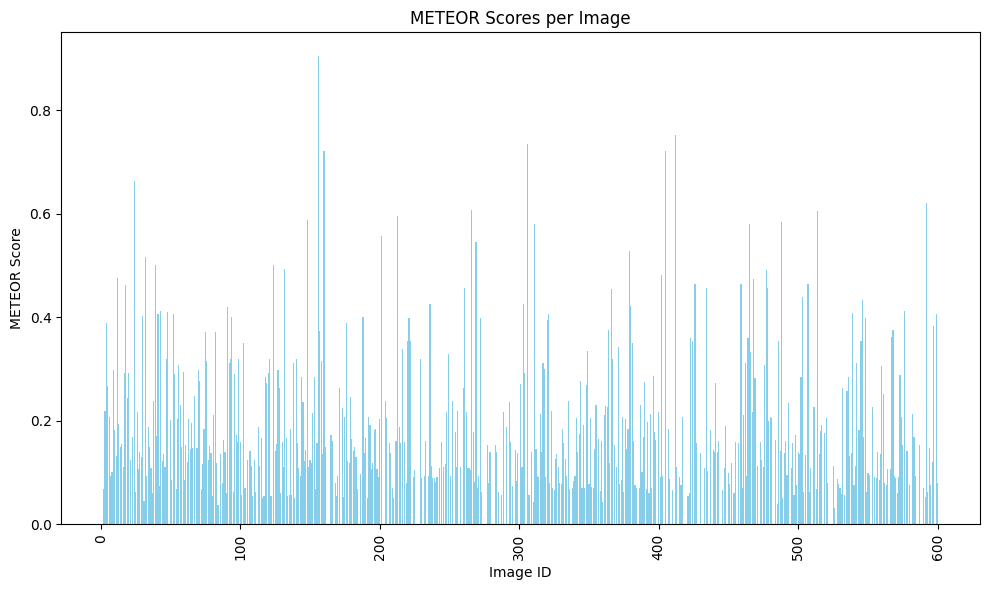

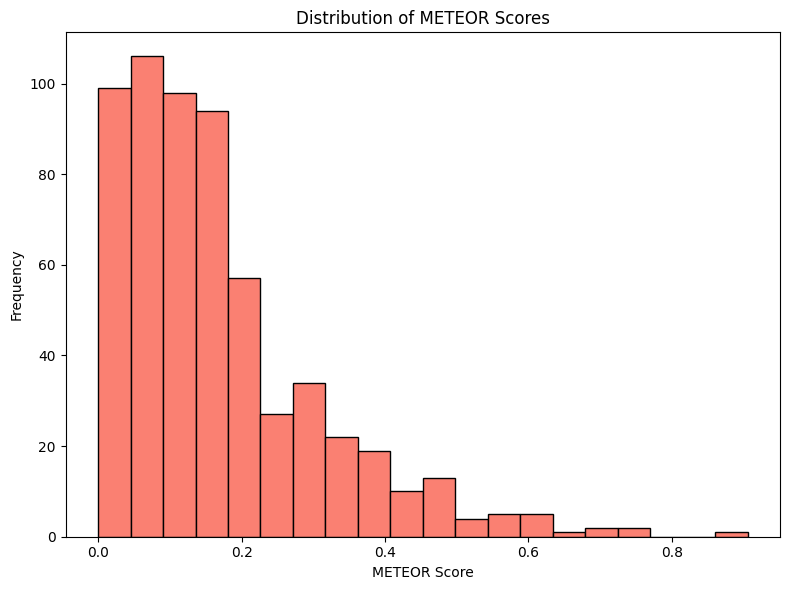

Visualizations saved as 'meteor_scores_bar_chart.png' and 'meteor_scores_histogram.png'.


In [101]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/vit-gpt2-captions.json"  
main_func(predictions_file, groundtruth_file)

# METEOR Distribution Git with Ground Truth

Average METEOR score: 0.2207


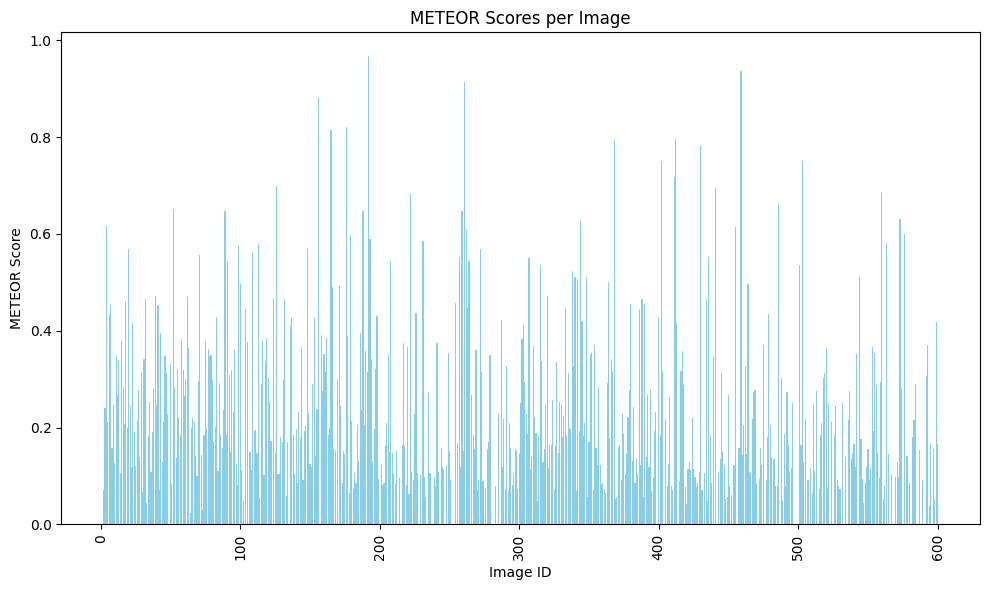

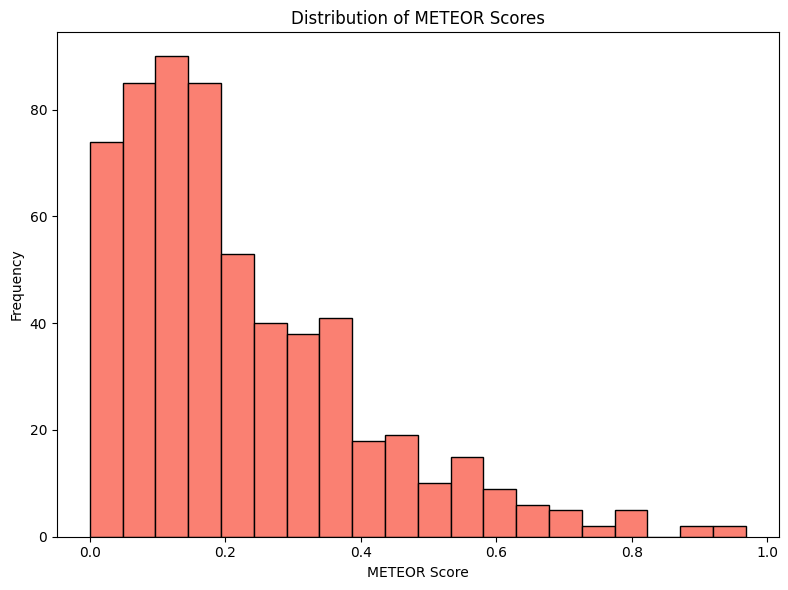

Visualizations saved as 'meteor_scores_bar_chart.png' and 'meteor_scores_histogram.png'.


In [102]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/git.json"  
main_func(predictions_file, groundtruth_file)

# METEOR Distribution blip-unconditional with Ground Truth

Average METEOR score: 0.2426


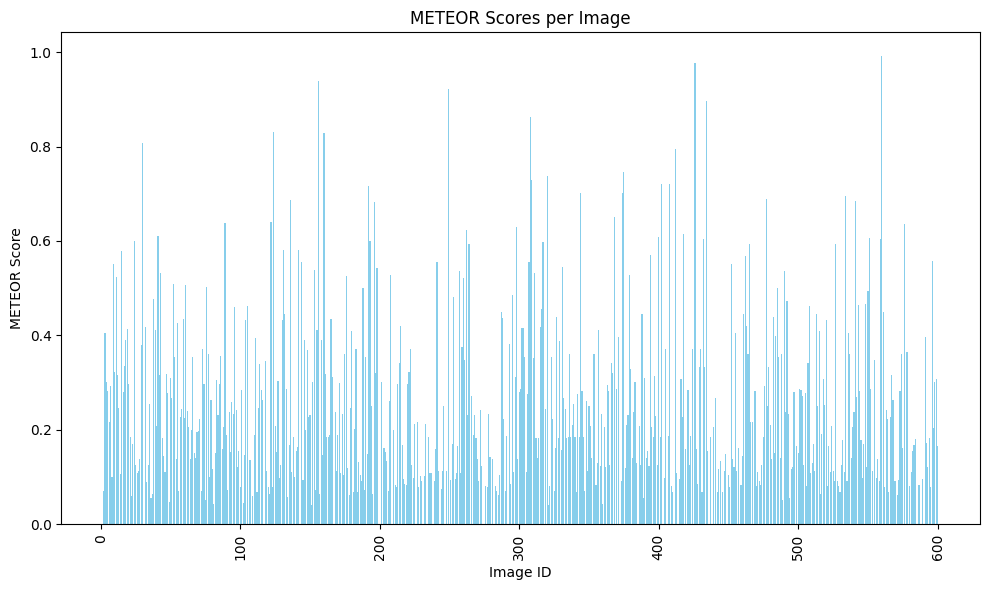

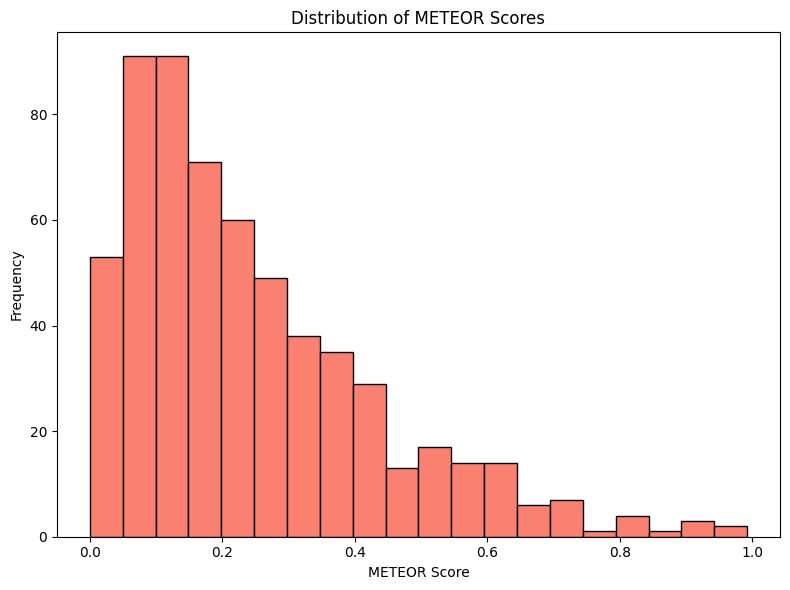

Visualizations saved as 'meteor_scores_bar_chart.png' and 'meteor_scores_histogram.png'.


In [103]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/blip-unconditional-captions.json"  
main_func(predictions_file, groundtruth_file)

In [114]:
# METEOR Distribution blip-conditional Ground Truth

Average METEOR score: 0.2418


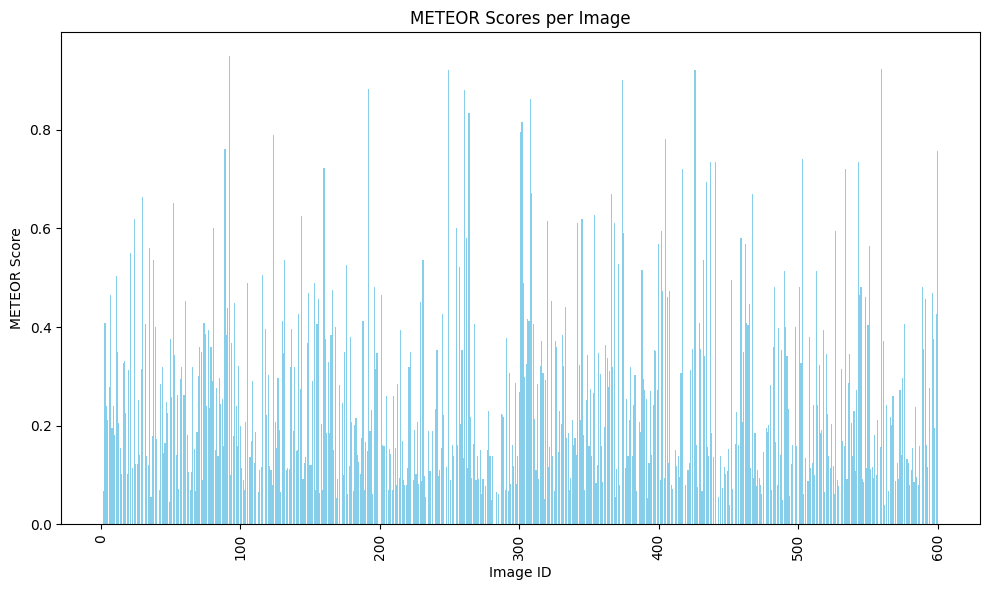

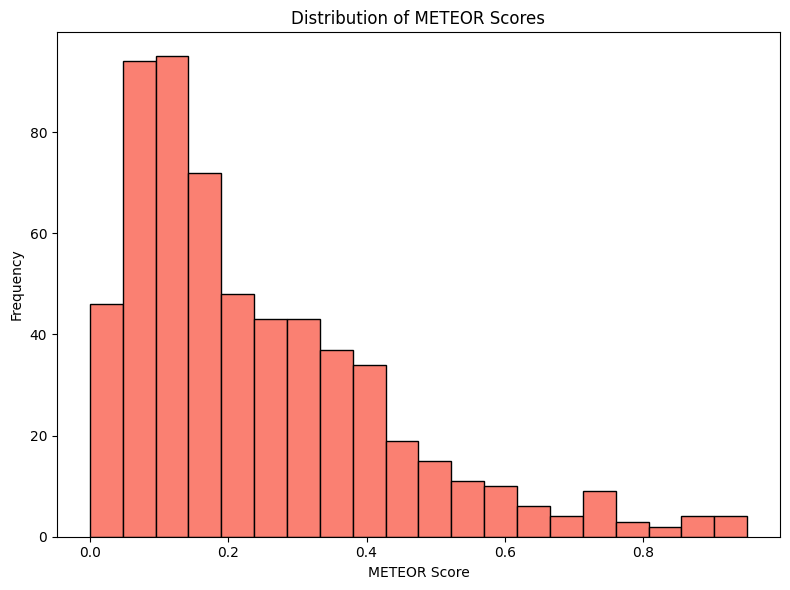

Visualizations saved as 'meteor_scores_bar_chart.png' and 'meteor_scores_histogram.png'.


In [104]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_file = "./captions/blip-conditional-captions.json"  
main_func(predictions_file, groundtruth_file)

In [117]:
def visualize_average_meteor(models_averages, output_file='average_meteor_comparison.png'):
    """Visualize average METEOR scores for multiple models."""
    models = list(models_averages.keys())
    averages = list(models_averages.values())

    plt.figure(figsize=(12, 8))
    bars = plt.bar(models, averages, color=plt.cm.tab20.colors[:len(models)])
    plt.xlabel('Models')
    plt.ylabel('Average METEOR Score')
    plt.title('Average METEOR Scores Comparison')
    plt.ylim(0, 1)

    # Add value labels on top of bars
    for bar, avg in zip(bars, averages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{avg}', ha='center', va='bottom')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig(output_file)
    plt.show()
    plt.close()
    print(f"Average METEOR comparison saved as '{output_file}'.")


def visualize_meteor_distributions(models_scores, output_file='meteor_distributions_comparison.png'):
    """Visualize METEOR score distributions for multiple models."""
    plt.figure(figsize=(12, 8))

    for model, scores in models_scores.items():
        score_values = list(scores.values())
        plt.hist(score_values, bins=20, alpha=0.5, label=model)

    plt.xlabel('METEOR Score')
    plt.ylabel('Frequency')
    plt.title('METEOR Score Distributions Comparison')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    # plt.savefig(output_file)
    plt.close()
    print(f"METEOR distributions comparison saved as '{output_file}'.")


def visualize_boxplot_meteor(models_scores, output_file='meteor_boxplot_comparison.png'):
    """Visualize boxplots of METEOR scores for multiple models."""
    plt.figure(figsize=(12, 8))

    data = [list(scores.values()) for scores in models_scores.values()]
    models = list(models_scores.keys())

    plt.boxplot(data, labels=models, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red'))

    plt.xlabel('Models')
    plt.ylabel('METEOR Score')
    plt.title('METEOR Scores Boxplot Comparison')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # plt.savefig(output_file)
    plt.close()
    print(f"METEOR boxplot comparison saved as '{output_file}'.")


def compare_models(groundtruth_file, predictions_files, model_names=None):
    """
    Compare multiple models by computing and visualizing their METEOR scores.

    :param groundtruth_file: Path to ground truth JSON file.
    :param predictions_files: List of prediction JSON file paths.
    :param model_names: Optional list of model names. If None, filenames are used.
    """
    if model_names is None:
        model_names = [f.split('.')[0] for f in predictions_files]

    ground_truth = load_annotations(groundtruth_file)

    models_scores = {}
    models_averages = {}

    for model, pred_file in zip(model_names, predictions_files):
        print(f"Processing model: {model}")
        predicted = load_annotations(pred_file)
        scores = compute_meteor_scores(ground_truth, predicted)
        average = calculate_average_score(scores)
        if average is not None:
            models_scores[model] = scores
            models_averages[model] = average
            print(f"{model} - Average METEOR: {average}")
        else:
            print(f"{model} - No scores to average.")

    # Visualize average METEOR scores
    visualize_average_meteor(models_averages)

    # Visualize METEOR score distributions
    visualize_meteor_distributions(models_scores)

    # Visualize boxplot of METEOR scores
    visualize_boxplot_meteor(models_scores)






Processing model: blip-unconditional-captions
blip-unconditional-captions - Average METEOR: 0.2426
Processing model: git
git - Average METEOR: 0.2207
Processing model: blip-conditional-captions
blip-conditional-captions - Average METEOR: 0.2418
Processing model: vit-gpt2-captions
vit-gpt2-captions - Average METEOR: 0.1644


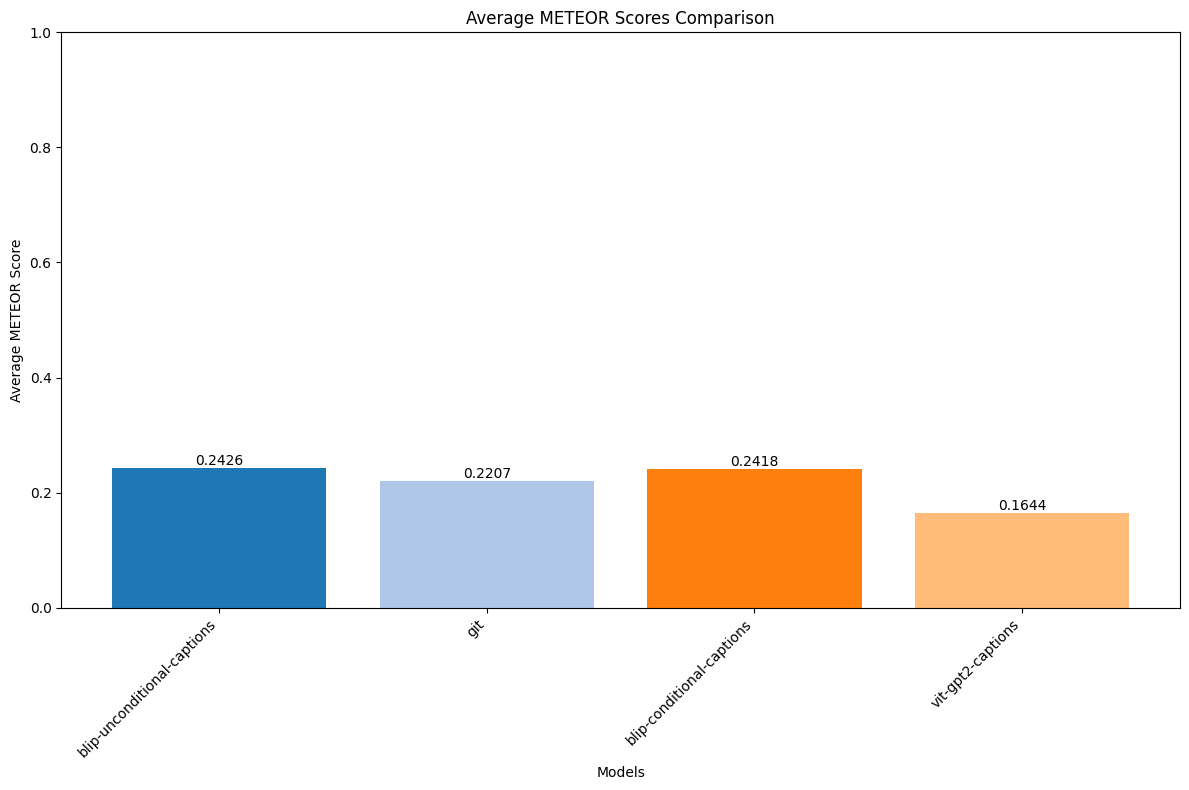

Average METEOR comparison saved as 'average_meteor_comparison.png'.


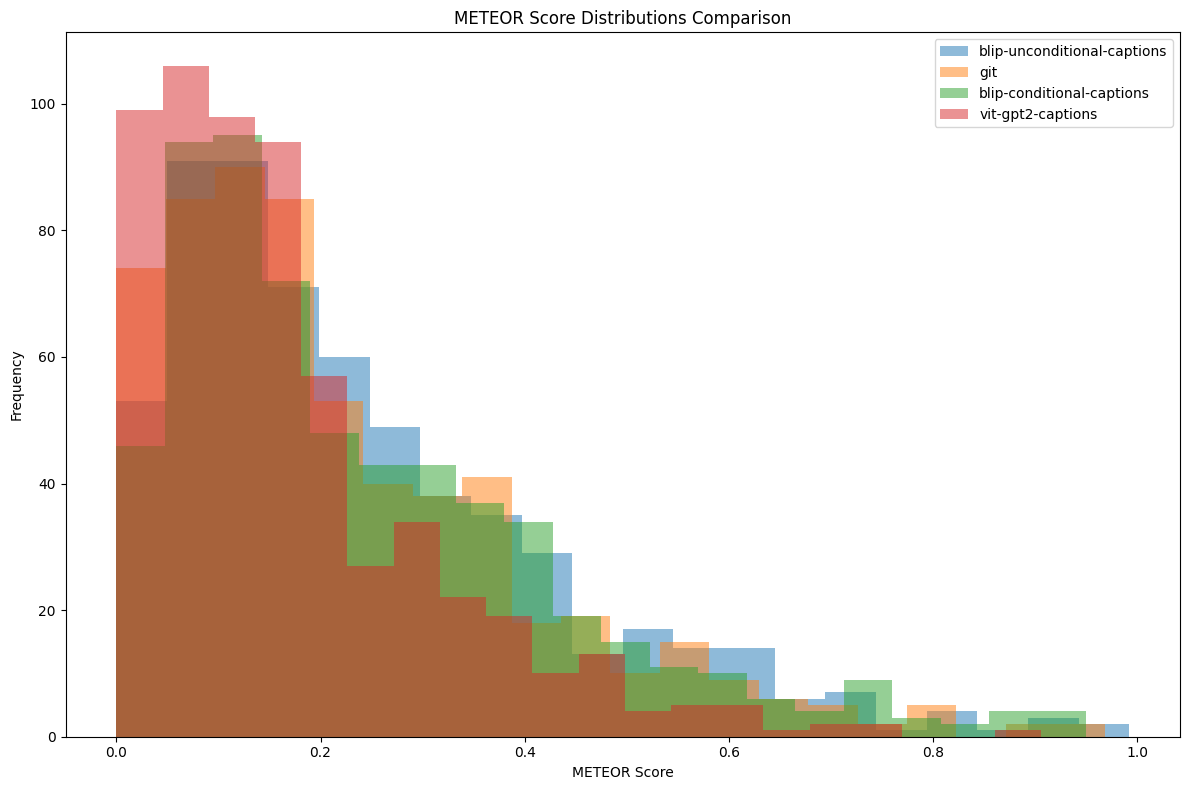

METEOR distributions comparison saved as 'meteor_distributions_comparison.png'.


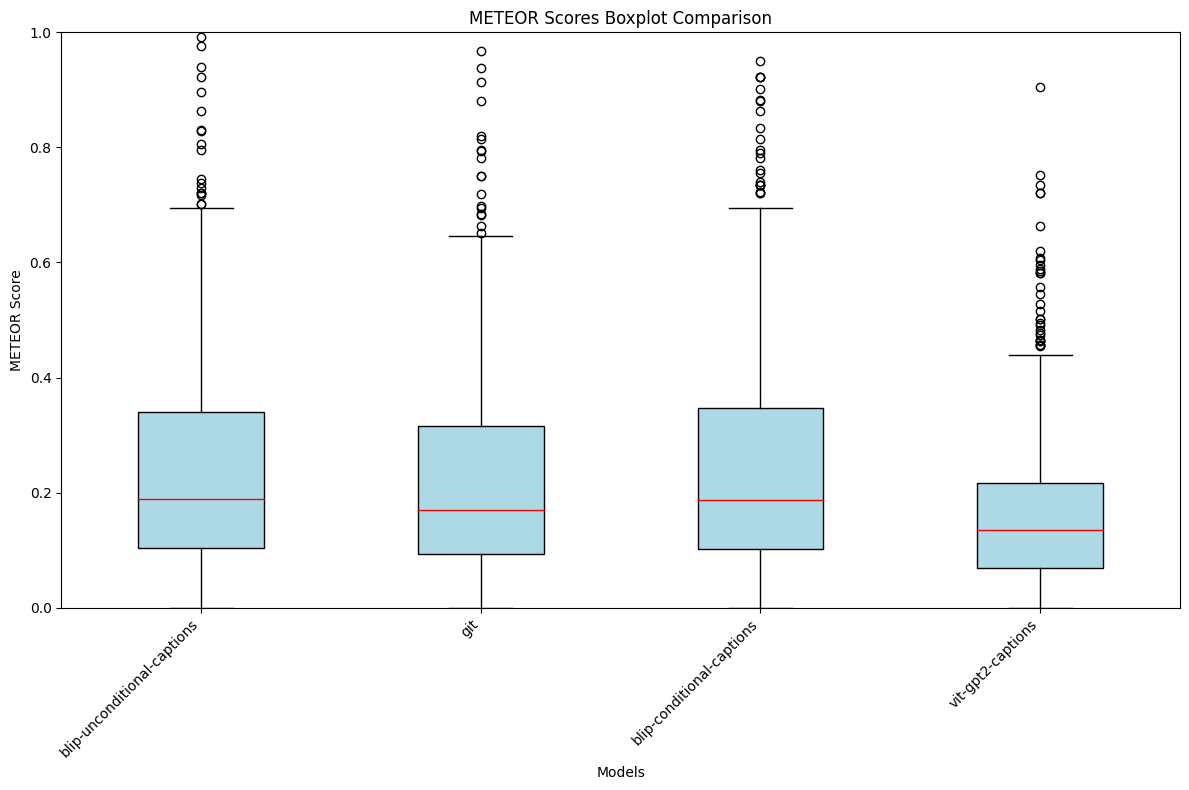

METEOR boxplot comparison saved as 'meteor_boxplot_comparison.png'.


In [118]:
groundtruth_file = "./captions/groundtruth-captions.json"  
predictions_files = ["./captions/blip-unconditional-captions.json","./captions/git.json","./captions/blip-conditional-captions.json" ,"./captions/vit-gpt2-captions.json"   ]
compare_models(groundtruth_file, predictions_files, model_names = ['blip-unconditional-captions','git','blip-conditional-captions','vit-gpt2-captions'])